In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import os


In [21]:

# ✅ Load segmented data
X = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/X_segments.npy")
y = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/y_labels.npy")
print(f"Original class distribution: {Counter(y)}") 


Original class distribution: Counter({0: 784535, 1: 4467, 5: 2466, 2: 1093})


In [22]:



# ✅ Flatten + scale
X_flat = X.reshape((X.shape[0], -1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)


In [23]:

# ✅ Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [24]:
# ✅ SMOTE + undersample
minority_classes = [cls for cls in Counter(y_train) if cls != Counter(y_train).most_common(1)[0][0]]
largest_minority_count = max([Counter(y_train)[cls] for cls in minority_classes])
target_count = largest_minority_count * 10

smote_strategy = {cls: target_count for cls in Counter(y_train) if cls != Counter(y_train).most_common(1)[0][0]}
sm = SMOTE(random_state=42, sampling_strategy=smote_strategy)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

rus = RandomUnderSampler(sampling_strategy={cls: target_count for cls in Counter(y_train_res)}, random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train_res, y_train_res)

rus_test = RandomUnderSampler(
    sampling_strategy={cls: min(Counter(y_test).values()) for cls in np.unique(y_test)}, random_state=42)
X_test_bal, y_test_bal = rus_test.fit_resample(X_test, y_test)

print(f"Train: {Counter(y_train_bal)} | Test: {Counter(y_test_bal)}")

# ✅ Augmentation
import numpy as np

def add_jitter(signal, sigma=0.01):
    noise = np.random.normal(0, sigma, signal.shape)
    return signal + noise

def random_scaling(signal, min_scale=0.9, max_scale=1.1):
    scale = np.random.uniform(min_scale, max_scale)
    return signal * scale

augmented_X = []
augmented_y = []

for i in range(len(X_train_bal)):
    x = X_train_bal[i]
    y = y_train_bal[i]
    
    augmented_X.append(add_jitter(x))
    augmented_y.append(y)
    
    augmented_X.append(random_scaling(x))
    augmented_y.append(y)

X_train_aug = np.vstack((X_train_bal, np.array(augmented_X)))
y_train_aug = np.hstack((y_train_bal, np.array(augmented_y)))

print(f"Original train samples: {len(X_train_bal)} | After augmentation: {len(X_train_aug)}")

# ✅ Remap labels before reshaping
label_map = {0: 0, 1: 1, 2: 2, 5: 3}
class_names = [
    "Fusion beat", 
    "Normal beat", 
    "Supraventricular ectopic beat", 
    "Ventricular ectopic beat"
]

y_train_aug = np.array([label_map[label] for label in y_train_aug])
y_test_bal = np.array([label_map[label] for label in y_test_bal])

# ✅ Reshape for CNN
time_steps = X.shape[1]
X_train_cnn = X_train_aug.reshape((-1, 1, time_steps)).astype(np.float32)
X_test_cnn = X_test_bal.reshape((-1, 1, time_steps)).astype(np.float32)


Train: Counter({0: 35740, 1: 35740, 2: 35740, 5: 35740}) | Test: Counter({0: 219, 1: 219, 2: 219, 5: 219})
Original train samples: 142960 | After augmentation: 428880


In [25]:

# ✅ Tensors + datasets
X_train_tensor = torch.tensor(X_train_cnn)
y_train_tensor = torch.tensor(y_train_aug, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_cnn)
y_test_tensor = torch.tensor(y_test_bal, dtype=torch.long)

train_ds_full = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)


In [26]:

# ✅ Train/val split
val_size = int(0.2 * len(train_ds_full))
train_size = len(train_ds_full) - val_size
train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)


In [27]:

# ✅ CNN model
class ECG_CNN(nn.Module):
    def __init__(self, num_classes):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [28]:

num_classes = len(class_names)
model = ECG_CNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [29]:
# ✅ Training loop + history + early stopping
num_epochs = 50
patience = 5  # Stop if no val loss improvement after 5 epochs
best_val_loss = float('inf')
counter = 0

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # ✅ Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Epoch 1/50, Train Loss: 0.6172, Val Loss: 0.4900, Train Acc: 0.7673, Val Acc: 0.8217
Epoch 2/50, Train Loss: 0.3296, Val Loss: 0.2646, Train Acc: 0.8833, Val Acc: 0.9074
Epoch 3/50, Train Loss: 0.2321, Val Loss: 0.1873, Train Acc: 0.9178, Val Acc: 0.9348
Epoch 4/50, Train Loss: 0.1868, Val Loss: 0.1584, Train Acc: 0.9347, Val Acc: 0.9467
Epoch 5/50, Train Loss: 0.1585, Val Loss: 0.1488, Train Acc: 0.9457, Val Acc: 0.9497
Epoch 6/50, Train Loss: 0.1389, Val Loss: 0.1307, Train Acc: 0.9525, Val Acc: 0.9537
Epoch 7/50, Train Loss: 0.1237, Val Loss: 0.1152, Train Acc: 0.9580, Val Acc: 0.9620
Epoch 8/50, Train Loss: 0.1134, Val Loss: 0.0934, Train Acc: 0.9618, Val Acc: 0.9684
Epoch 9/50, Train Loss: 0.1037, Val Loss: 0.0936, Train Acc: 0.9651, Val Acc: 0.9676
Epoch 10/50, Train Loss: 0.0958, Val Loss: 0.1088, Train Acc: 0.9676, Val Acc: 0.9621
Epoch 11/50, Train Loss: 0.0884, Val Loss: 0.0946, Train Acc: 0.9708, Val Acc: 0.9690
Epoch 12/50, Train Loss: 0.0836, Val Loss: 0.0809, Train Acc: 0

KeyboardInterrupt: 

In [30]:

# ✅ Save model + history
save_dir = "C:/Users/arfao/Desktop/stage_2025/cnn_results"

os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_dir, 'ecg_cnn_model.pth'))
np.save(os.path.join(save_dir, 'ecg_cnn_history.npy'), history)
print(f"Model and history saved to {save_dir}")


Model and history saved to C:/Users/arfao/Desktop/stage_2025/cnn_results


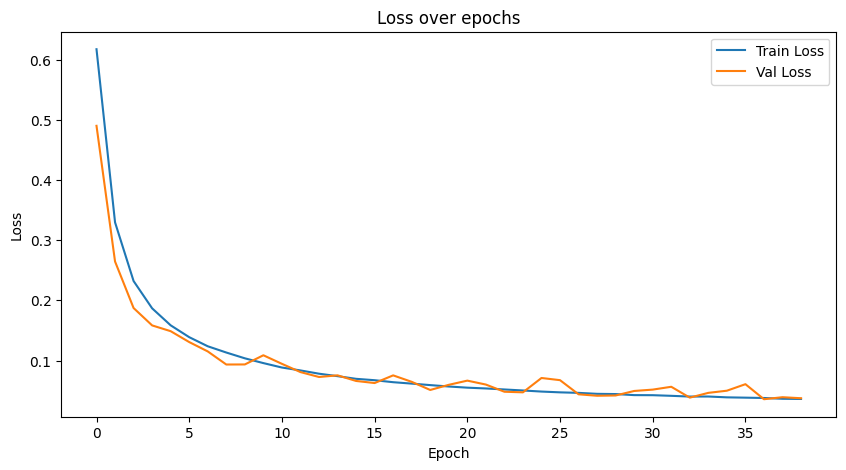

In [31]:


# ✅ Plot loss
plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


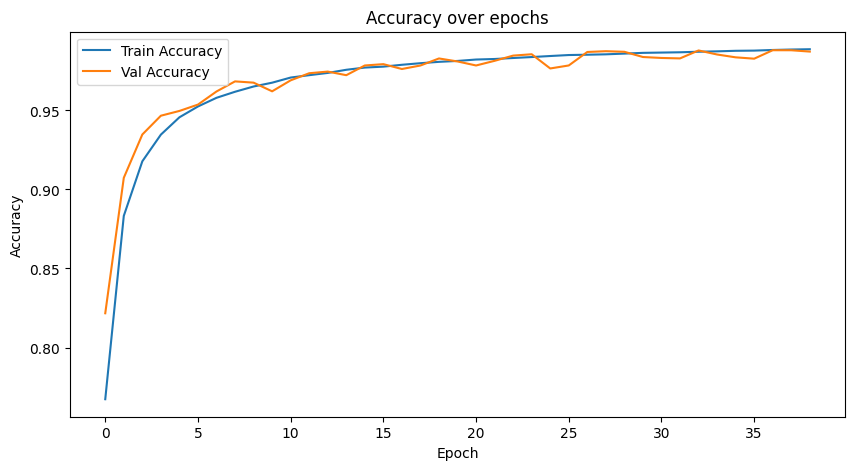

In [32]:

# ✅ Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [33]:

# ✅ Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

y_test_named = [class_names[i] for i in all_labels]
y_pred_named = [class_names[i] for i in all_preds]

print("Classification Report (Balanced Test Set - CNN):")
print(classification_report(y_test_named, y_pred_named, labels=class_names))


Classification Report (Balanced Test Set - CNN):
                               precision    recall  f1-score   support

                  Fusion beat       0.71      0.95      0.81       219
                  Normal beat       0.93      0.96      0.95       219
Supraventricular ectopic beat       0.96      0.62      0.75       219
     Ventricular ectopic beat       0.93      0.91      0.92       219

                     accuracy                           0.86       876
                    macro avg       0.88      0.86      0.86       876
                 weighted avg       0.88      0.86      0.86       876



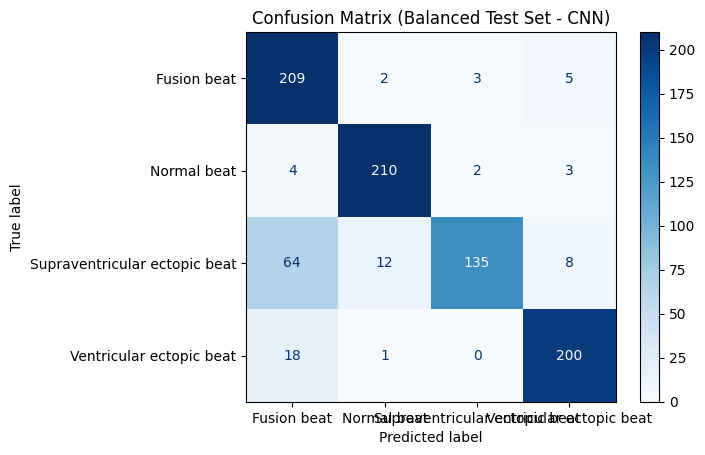

In [34]:

cm = confusion_matrix(y_test_named, y_pred_named, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Balanced Test Set - CNN)")
plt.show()


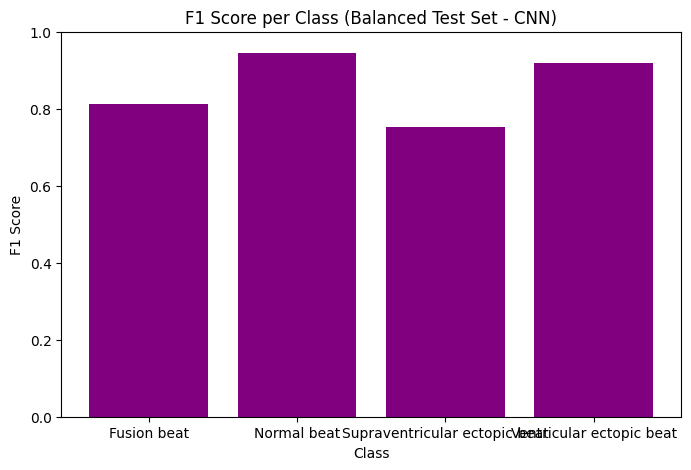

In [35]:

f1_per_class = f1_score(y_test_named, y_pred_named, labels=class_names, average=None)
plt.figure(figsize=(8, 5))
plt.bar(class_names, f1_per_class, color='purple')
plt.title('F1 Score per Class (Balanced Test Set - CNN)')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()


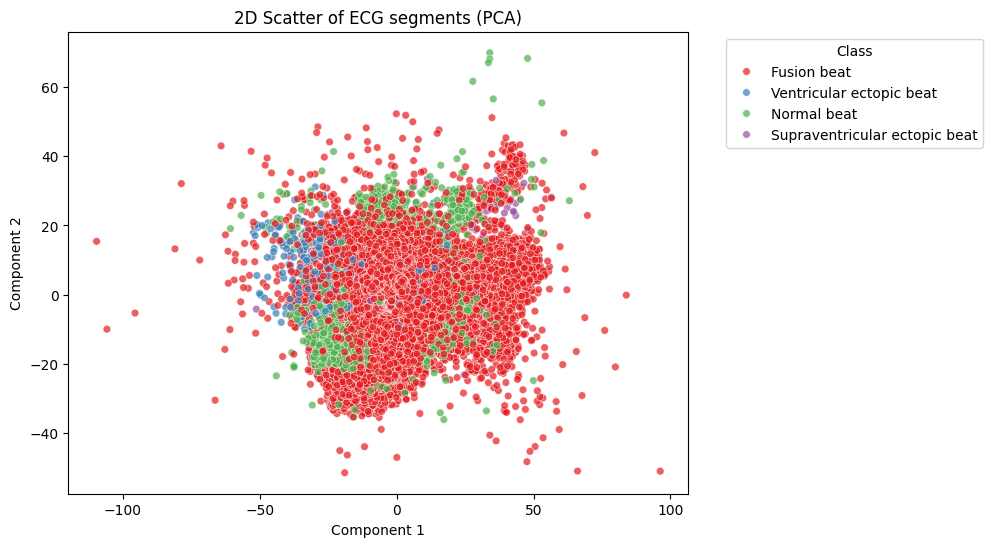

In [36]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load your segmented + labeled data
X = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/X_segments.npy")
y = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/y_labels.npy")

# ✅ Flatten + scale if needed
X_flat = X.reshape((X.shape[0], -1))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# ✅ Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# ✅ Class names and mapping
label_map = {0: 0, 1: 1, 2: 2, 5: 3}
class_names = [
    "Fusion beat", 
    "Normal beat", 
    "Supraventricular ectopic beat", 
    "Ventricular ectopic beat"
]

y_mapped = np.array([label_map[label] for label in y if label in label_map])

# ✅ Apply same PCA transform to matching labels
X_pca = X_pca[:len(y_mapped)]

# ✅ Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=[class_names[i] for i in y_mapped], 
                palette="Set1", s=30, alpha=0.7)
plt.title("2D Scatter of ECG segments (PCA)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
